In [1]:
import os
os.chdir("../")

# # Set R environment variables using the conda environment path
# r_home = '/sfs/gpfs/tardis/home/jq2uw/llm_nicu_vitalsigns/clip_env/lib/R'
# os.environ['R_HOME'] = r_home
# os.environ['R_LIBS'] = f"{r_home}/library"
# os.environ['R_LIBS_USER'] = os.path.expanduser('~/R/goolf/4.3')
# os.environ['LD_LIBRARY_PATH'] = f"{r_home}/lib:" + os.environ.get('LD_LIBRARY_PATH', '')

import torch
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()

In [2]:
from config import *
from data import *
from train import *
from eval import *
from model_utils.vital_raw import *
print("using device: ", device)

Random seed set to 333
using device:  cpu


## Customize Configuration

In [3]:
# (customize) configs
overwrite = True
model_name = 'testclip'
text_config['cl']['die7d'] = True # udpate text_config here if needed
# text_config['split'] = True
# text_config['demo']['gre'] = True
# text_config['demo']['apgar_mage'] = True
model_name = model_name + "___" + "_".join(get_true_components(text_config))

update_config(
    text_col_ls = ['cl_event', 'ts_description', 'demo'],#], 'demo_ga', 'demo_weight', 'demo_apgar', 'demo_mother'],
    model_name = model_name,
    downsample = True,
    downsample_size = 1,
    embedded_dim = 512,
    batch_size = 2048, # Data loader settings
    patience = 100, # Training settings
    num_saves = 1000,
    num_epochs = 100,
    init_lr = 5e-5,
    text_config = text_config,
    **{'3d': True}  # Add this line
)
config_dict = get_config_dict()

In [4]:
# run preprocess.py to ready the data
with open('main_preprocess.py', 'r') as file:
    exec(file.read())


Sample of patients with positive labels:
VitalID
1018    8
5170    8
1464    8
2361    8
2791    8
dtype: int64


[Parallel(n_jobs=9)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done  32 tasks      | elapsed:    3.7s
[Parallel(n_jobs=9)]: Done 2596 tasks      | elapsed:    4.3s
[Parallel(n_jobs=9)]: Done 62812 tasks      | elapsed:   12.5s
[Parallel(n_jobs=9)]: Done 65353 out of 65353 | elapsed:   12.7s finished


This infant will survive.  This infant has gestational age 24 weeks. Birth weight is 360 grams.  Moderate variability.  Very low amount of consecutive increases. Very high amount of consecutive unchanging values.    

Sample of patients with positive labels:
TestID
817     8
1903    8
801     8
508     8
2518    8
dtype: int64


[Parallel(n_jobs=9)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=9)]: Done 14318 tasks      | elapsed:    2.1s
[Parallel(n_jobs=9)]: Done 61182 tasks      | elapsed:    7.9s
[Parallel(n_jobs=9)]: Done 61570 out of 61570 | elapsed:    7.9s finished


This infant will survive.  This infant has gestational age 33 weeks. Birth weight is 2630 grams.  High variability.  Low amount of consecutive increases. Very high amount of consecutive unchanging values.    
After downsampling:
cl_event
This infant will die in 7 days.     384
This infant will survive.             1
Name: count, dtype: int64
After downsampling:
cl_event
This infant will die in 7 days.     241
This infant will survive.             1
Name: count, dtype: int64


/Users/joyqiu/Documents/Documents JoyQiu Work/Research/LLMTimeSeries/llm_nicu_vitalsigns/clip_env/lib/python3.11/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


cl_event
This infant will die in 7 days.     384
This infant will survive.             1
Name: count, dtype: int64
cl_event
This infant will die in 7 days.     241
This infant will survive.             1
Name: count, dtype: int64


## Customize VITAL Model

In [5]:
# customize model
if overwrite:    
    # check if ts_f_dim is already in the memory
    if 'ts_f_dim' not in locals():
        # just to get the dimension out
        if config_dict['3d']:
            ts_f_dim, tx_f_dim_ls, labels_dim = get_features3d(df_train.iloc[:1,:], config_dict, text_col_ls = config_dict['text_col_ls'])
        else:
            ts_f_dim, tx_f_dim, labels_dim = get_features(df_train.iloc[:1,:], config_dict)
    
    ts_encoder = None
    ts_decoder = None
    if config_dict['3d']:
        model = VITAL3D(
                    ts_dim=ts_f_dim.shape[1],
                    text_dim=tx_f_dim_ls[0].shape[1],
                    n_text=len(tx_f_dim_ls),
                    output_dim=config_dict['embedded_dim'],
                    ts_encoder=ts_encoder,
                    ts_decoder=ts_decoder
                )
    else:
        model = VITAL(
                    ts_dim=ts_f_dim.shape[1],
                    text_dim=tx_f_dim.shape[1],
                    output_dim=config_dict['embedded_dim'],
                    ts_encoder=ts_encoder,
                    ts_decoder=ts_decoder
                )
    update_config(model_init = model)
    config_dict = get_config_dict()
    
    # ------------------------- ready training -------------------------
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=config_dict['init_lr'],
        weight_decay=1e-4
    )

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, 
        mode='min',
        factor=0.9,         
        patience=config_dict['patience'],       
        verbose=True,
        min_lr=1e-20,        
        threshold=1e-4,      
        cooldown=20          
    )

    kl_annealer = KLAnnealer(start=1.0, 
                             end=1.0, 
                             epochs=10000) # for the first 1000 epochs, favor reconstruction more


    train_eval_metrics_ts2txt_list = []
    test_eval_metrics_ts2txt_list = []
    train_eval_metrics_txt2ts_list = []
    test_eval_metrics_txt2ts_list = []
    train_losses = []
    test_losses = []

    
    # ------------------------- ready output directory -------------------------
    import shutil
    if os.path.exists(output_dir):
        shutil.rmtree(output_dir)
    os.makedirs(output_dir)
    config_dict['model_init'] = model
    torch.save(config_dict, config_path)
    overwrite = False # reset overwrite to False
else:
    config_dict = torch.load(config_path)
    model = config_dict['model_init']


Layer (type:depth-idx)                                                 Param #
VITAL3D                                                                1
├─TSVAEEncoder: 1-1                                                    --
│    └─LocalNorm: 2-1                                                  --
│    └─Sequential: 2-2                                                 --
│    │    └─MultiLSTMEncoder: 3-1                                      3,295,104
│    │    └─LayerNorm: 3-2                                             512
│    │    └─Linear: 3-3                                                131,584
│    │    └─LeakyReLU: 3-4                                             --
│    │    └─LayerNorm: 3-5                                             1,024
│    │    └─Linear: 3-6                                                262,656
│    │    └─LeakyReLU: 3-7                                             --
│    │    └─LayerNorm: 3-8                                             1,024
│    │    

/Users/joyqiu/Documents/Documents JoyQiu Work/Research/LLMTimeSeries/llm_nicu_vitalsigns/clip_env/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [6]:
overwrite = False
if overwrite or not os.path.exists(model_path):
    for i in range(config_dict['num_saves']):  # n_evals
        train_losses_tmp, test_losses_tmp = train_vital(model, 
                                                        train_dataloader,
                                                        test_dataloader, 
                                                        optimizer, 
                                                        scheduler,
                                                        kl_annealer,
                                                        num_epochs=config_dict['num_epochs'], 
                                                        train_type='clip')
        train_losses = train_losses + train_losses_tmp
        test_losses = test_losses + test_losses_tmp
        # every num_epochs, evaluate the model
        model.eval()
        if config_dict['3d']:
            train_eval_metrics_ts2txt = eval_clip3d_ts2txt(model, evalclipts2txt_train)
            test_eval_metrics_ts2txt = eval_clip3d_ts2txt(model, evalclipts2txt_test)
            train_eval_metrics_txt2ts = eval_clip3d_txt2ts(model, evalcliptxt2ts_train)
            test_eval_metrics_txt2ts = eval_clip3d_txt2ts(model, evalcliptxt2ts_test)

        else:
            train_eval_metrics_ts2txt = eval_clip_ts2txt(model, evalclipts2txt_train)
            test_eval_metrics_ts2txt = eval_clip_ts2txt(model, evalclipts2txt_test)
            train_eval_metrics_txt2ts = eval_clip_txt2ts(model, evalcliptxt2ts_train)
            test_eval_metrics_txt2ts = eval_clip_txt2ts(model, evalcliptxt2ts_test)

        train_eval_metrics_ts2txt_list.append(train_eval_metrics_ts2txt)
        test_eval_metrics_ts2txt_list.append(test_eval_metrics_ts2txt)
        eval_dict_ts2txt = {'train_losses': train_losses,
                    'test_losses': test_losses,
                    'train_evals': train_eval_metrics_ts2txt_list,
                    'test_evals': test_eval_metrics_ts2txt_list }
        eval_dict_eng = eng_eval_metrics(eval_dict_ts2txt, binary=True, plot=False)
        print("-" * 70)
        print(f"Metric     |  Training  |  Testing")
        print("-" * 70)
        print(f"F1        |   {eval_dict_eng['train_f1'][-1]:.3f}   |   {eval_dict_eng['test_f1'][-1]:.3f}")
        print(f"Precision |   {eval_dict_eng['train_precision'][-1]:.3f}   |   {eval_dict_eng['test_precision'][-1]:.3f}")
        print(f"Recall    |   {eval_dict_eng['train_recall'][-1]:.3f}   |   {eval_dict_eng['test_recall'][-1]:.3f}")
        print(f"AUROC     |   {eval_dict_eng['train_auroc'][-1]:.3f}   |   {eval_dict_eng['test_auroc'][-1]:.3f}")
        print(f"AUPRC     |   {eval_dict_eng['train_auprc'][-1]:.3f}   |   {eval_dict_eng['test_auprc'][-1]:.3f}")
        print("-" * 70)

        train_eval_metrics_txt2ts_list.append(train_eval_metrics_txt2ts)
        test_eval_metrics_txt2ts_list.append(test_eval_metrics_txt2ts)
        eval_dict_txt2ts = {'train_losses': train_losses,
                    'test_losses': test_losses,
                    'train_evals': train_eval_metrics_txt2ts_list,
                    'test_evals': test_eval_metrics_txt2ts_list }
        eval_dict_eng = eng_eval_metrics(eval_dict_txt2ts, binary=False, plot=False)
        print("-" * 70)
        print(f"Metric     |  Training  |  Testing")
        print("-" * 70)
        print(f"F1        |   {eval_dict_eng['train_f1'][-1]:.3f}   |   {eval_dict_eng['test_f1'][-1]:.3f}")
        print(f"Precision |   {eval_dict_eng['train_precision'][-1]:.3f}   |   {eval_dict_eng['test_precision'][-1]:.3f}")
        print(f"Recall    |   {eval_dict_eng['train_recall'][-1]:.3f}   |   {eval_dict_eng['test_recall'][-1]:.3f}")
        print(f"AUROC     |   {eval_dict_eng['train_auroc'][-1]:.3f}   |   {eval_dict_eng['test_auroc'][-1]:.3f}")
        print(f"AUPRC     |   {eval_dict_eng['train_auprc'][-1]:.3f}   |   {eval_dict_eng['test_auprc'][-1]:.3f}")
        print("-" * 70)

        # save model and losses
        torch.save(model.state_dict(), model_path)
        torch.save(eval_dict_ts2txt, output_dir+'/evals_ts2txt.pth')
        torch.save(eval_dict_txt2ts, output_dir+'/evals_txt2ts.pth')
    
else:
    model.load_state_dict(torch.load(model_path))
    model.eval()
    eval_dict_ts2txt = torch.load(output_dir+'/evals_ts2txt.pth')
    eval_dict_txt2ts = torch.load(output_dir+'/evals_txt2ts.pth')
    eval_dict_eng = eng_eval_metrics(eval_dict_ts2txt, binary=True, plot=True)
    eval_dict_eng = eng_eval_metrics(eval_dict_txt2ts, binary=False, plot=True, plot_confusion_matrices=True)

Epoch [1/100]
	Training Loss: 9.641052
	Testing Loss: 7.655385
	Learning Rate: 0.000050000
beta: 1.0
Epoch [11/100]
	Training Loss: 8.727934
	Testing Loss: 7.150886
	Learning Rate: 0.000050000
beta: 1.0
Epoch [21/100]
	Training Loss: 8.207159
	Testing Loss: 6.985325
	Learning Rate: 0.000050000
beta: 1.0
Epoch [31/100]
	Training Loss: 8.791989
	Testing Loss: 7.140995
	Learning Rate: 0.000050000
beta: 1.0
Epoch [41/100]
	Training Loss: 9.060743
	Testing Loss: 7.055741
	Learning Rate: 0.000050000
beta: 1.0
Epoch [51/100]
	Training Loss: 8.551802
	Testing Loss: 7.096949
	Learning Rate: 0.000050000
beta: 1.0
Epoch [61/100]
	Training Loss: 8.594568
	Testing Loss: 7.427177
	Learning Rate: 0.000050000
beta: 1.0
Epoch [71/100]
	Training Loss: 9.775345
	Testing Loss: 7.214797
	Learning Rate: 0.000050000
beta: 1.0
Epoch [81/100]
	Training Loss: 8.236051
	Testing Loss: 7.571671
	Learning Rate: 0.000050000
beta: 1.0
Epoch [91/100]
	Training Loss: 8.363665
	Testing Loss: 7.683628
	Learning Rate: 0.0

KeyboardInterrupt: 

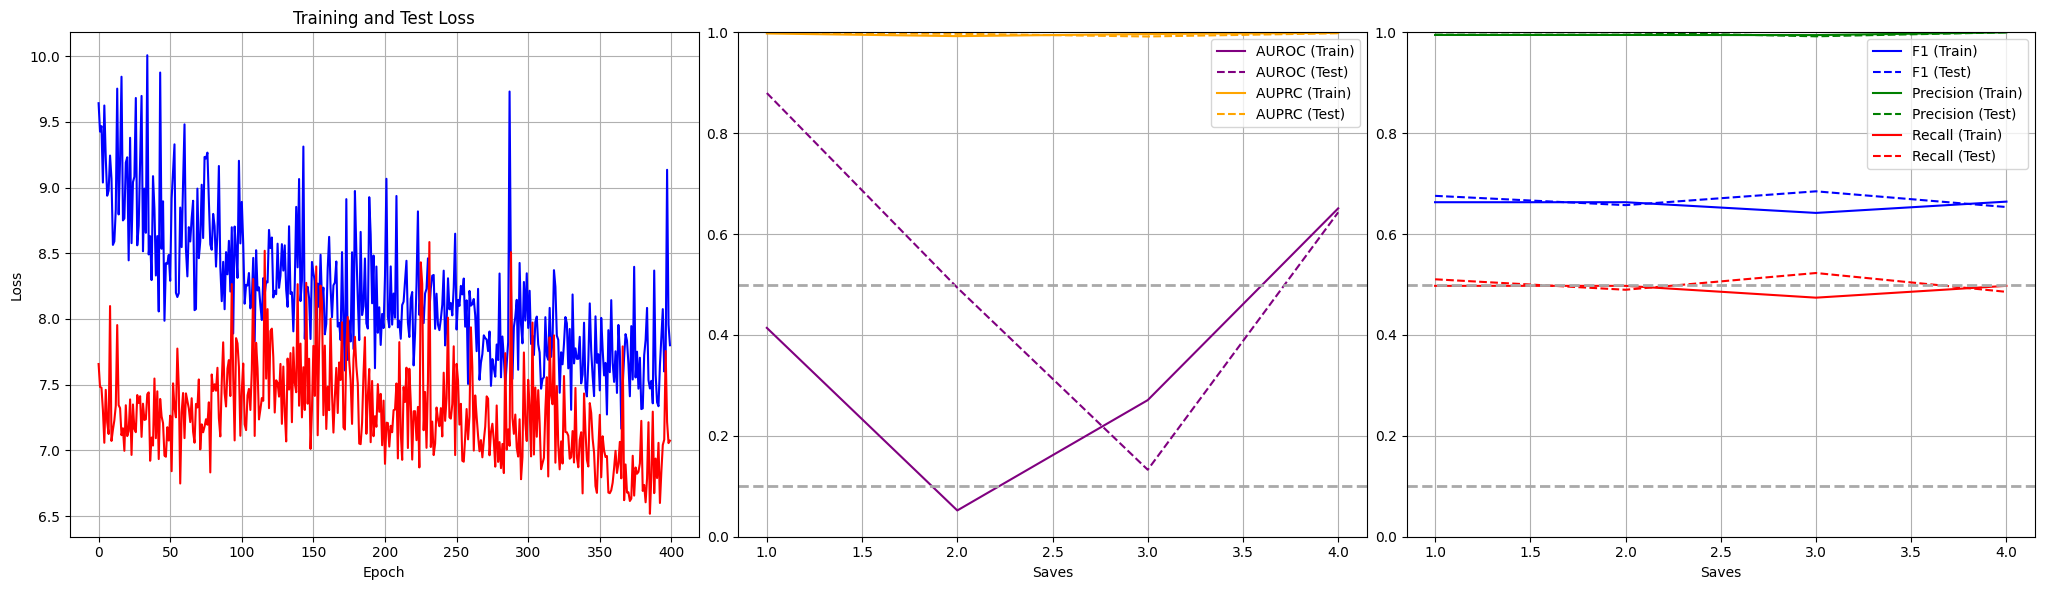

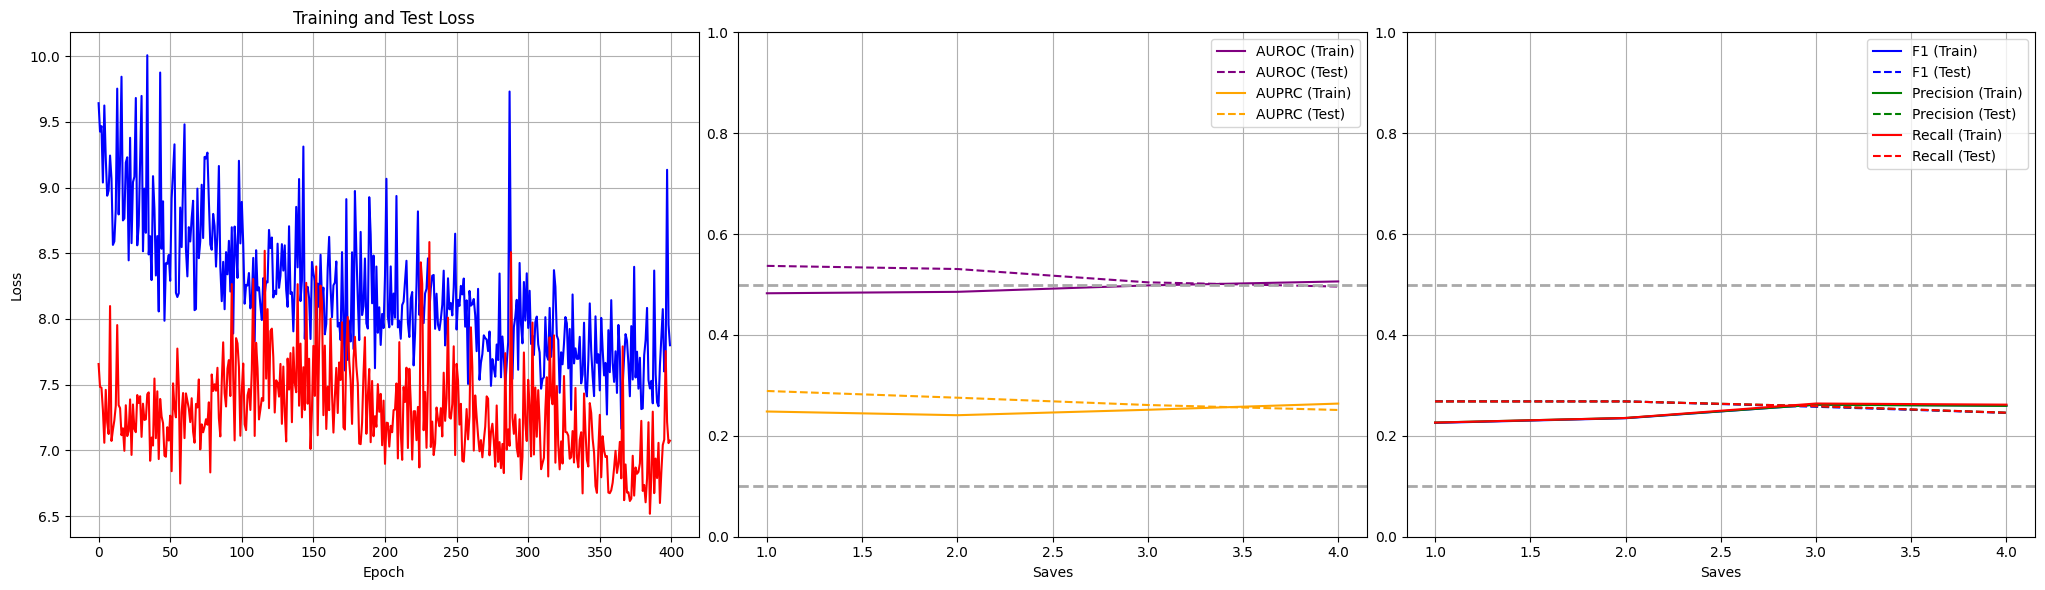

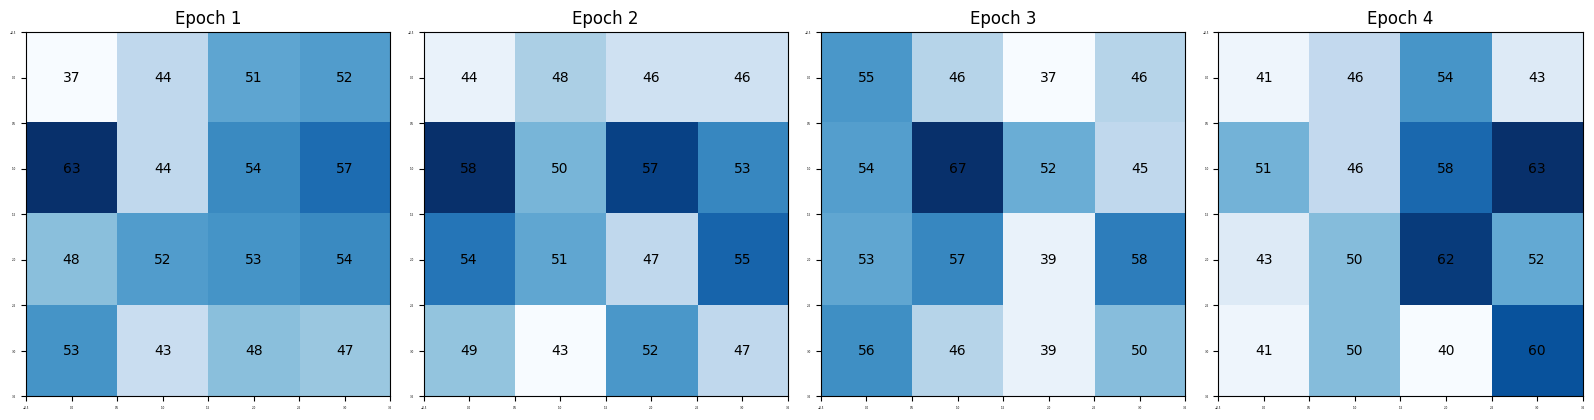

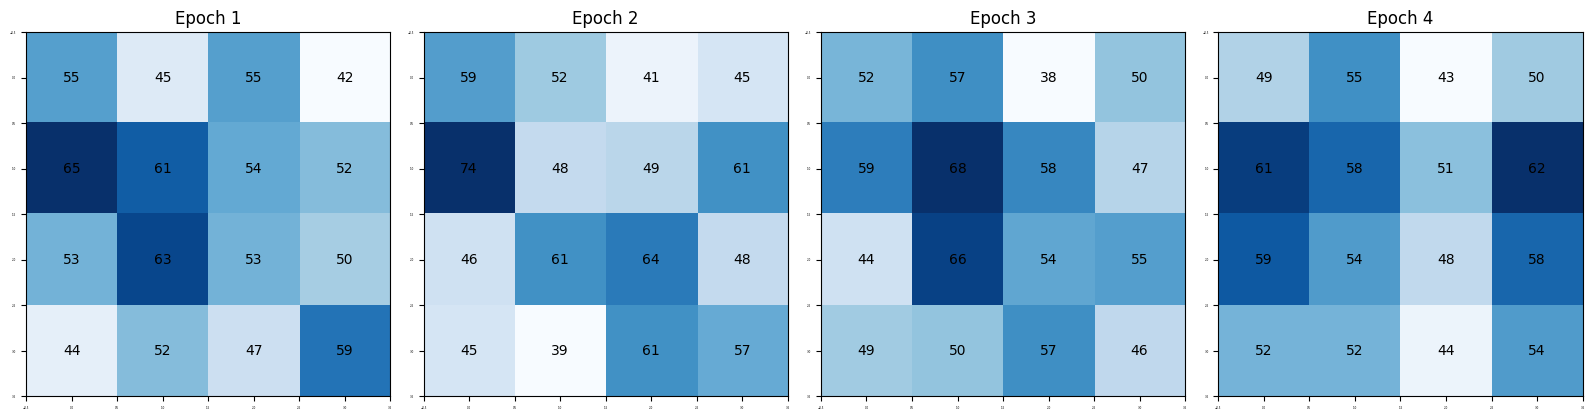

In [ ]:
eval_dict_eng = eng_eval_metrics(eval_dict_ts2txt, binary=True, plot=True)
eval_dict_eng = eng_eval_metrics(eval_dict_txt2ts, binary=False, plot=True, plot_confusion_matrices=True)

In [34]:
df = df_train.iloc[:1,].copy()
print(config_dict['text_col_ls'])
top_probs, top_ts_hats, top_distances = vital_infer(df, model, config_dict, text_col_ls=['text1', 'ts_description', 'demo'])


torch.Size([1, 500])


##### 